# Ranking the drawdowns of Index constituents

It is useful to keep a tab on drawdowns of index constituents to get a feel for how the index is diverging/converging from individual stock performance. For example, 7 stocks account for 50% of the NIFTY 50's performance and end up masking the performance of the other 43. If the rest are crashing, how long will the best hold up?

StockViz has an automated report on drawdowns of NIFTY 100, MIDCAP 150 and SMLCAP 100 constituents that gets generated everyday [here](https://stockviz.github.io/reports/drawdown/drawdowns.html). The [underlying code](https://github.com/stockviz/reports/tree/master/drawdown) is an R-markdown script who's output gets pushed to github. In this notebook, by setting the *indexName* variable to any NSE/NIFTY index that we have constituents for, you can generate the same report for yourself on [pluto](http://pluto.studio).

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(RPostgres)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
indices<-Indices()
equitiesIndiaNse <- EquitiesIndiaNse()

indexName <- "NIFTY 50"
endDate <- Sys.Date()
startDate <- endDate - 365 

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults

In [2]:
maxDt <- (indices$NseConstituents() %>%
          filter(NAME == indexName) %>%
          summarize(MAX_TS = max(TIME_STAMP)) %>% 
          collect())$MAX_TS[1]

constituents <- indices$NseConstituents() %>%
    filter(TIME_STAMP == maxDt & NAME == "NIFTY 50") %>%
    collect() %>%
    as.data.frame()

Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

### plot the weights to get a feel for individual contributions

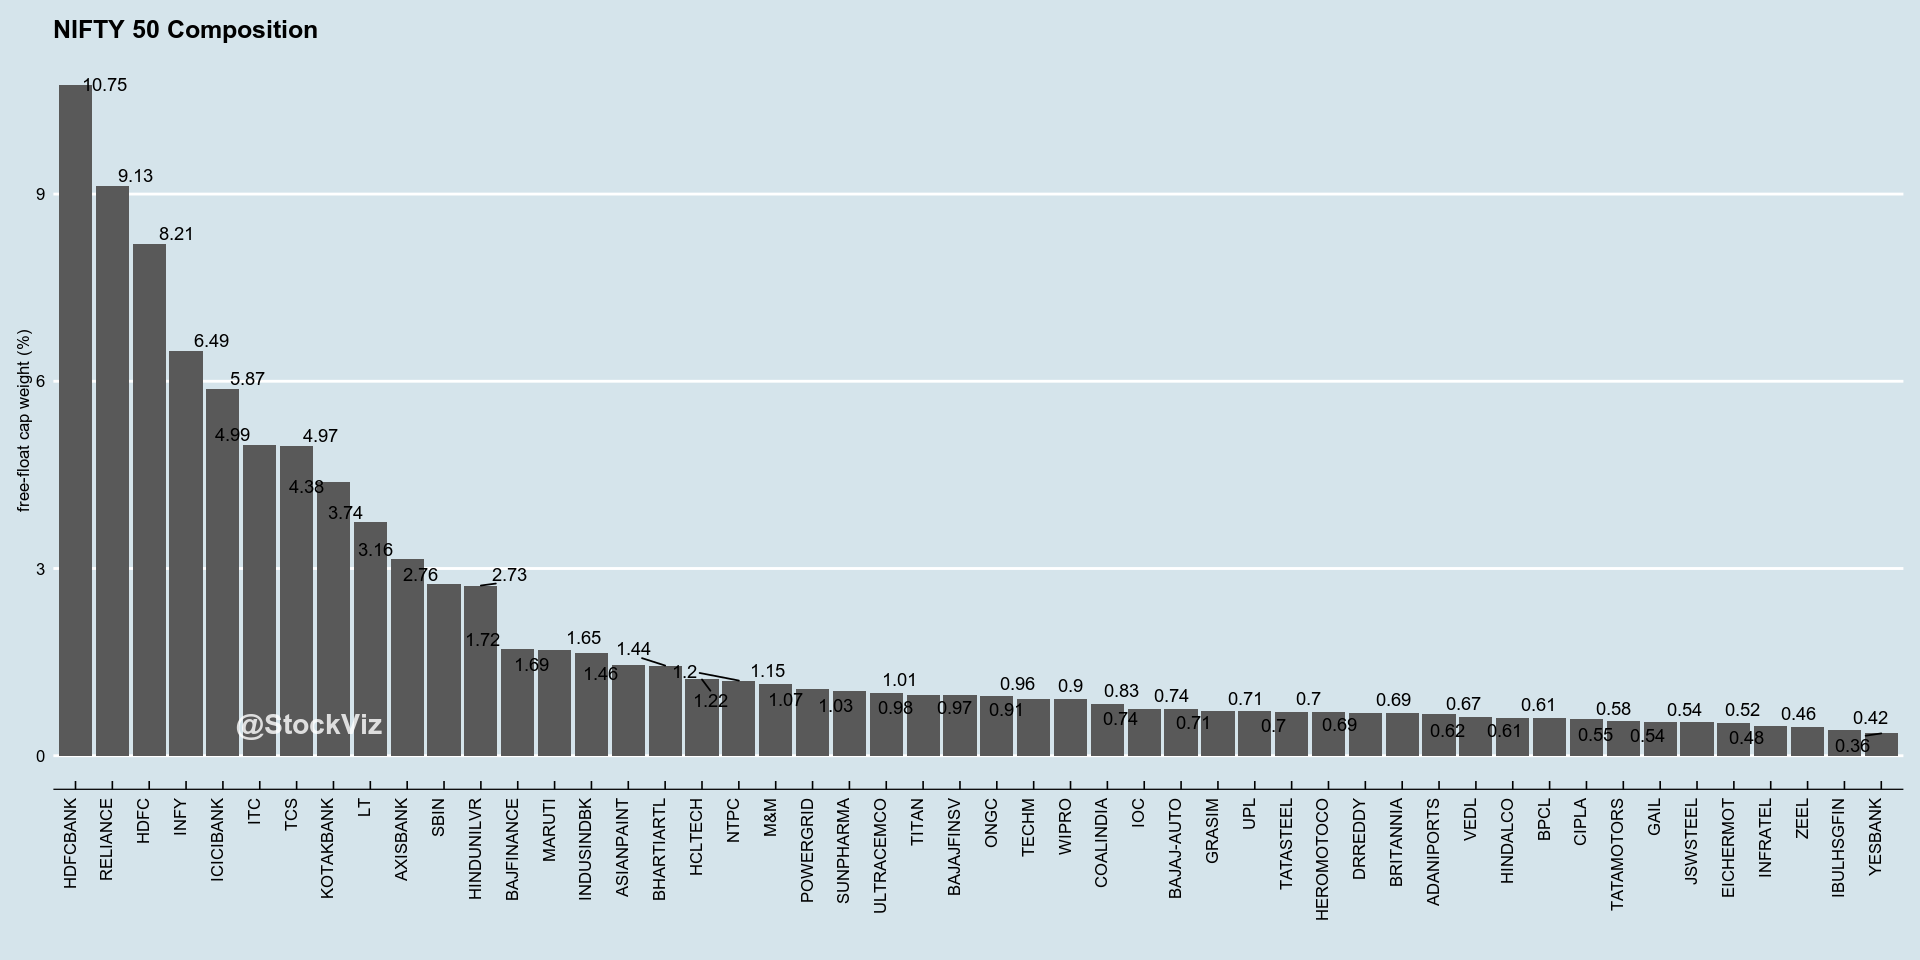

In [3]:
toPlot <- constituents

ggplot(toPlot, aes(x=reorder(SYMBOL, -CAP_WEIGHT), y=CAP_WEIGHT)) +
    theme_economist() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    geom_text_repel(aes(label=round(CAP_WEIGHT, 2)), position = position_dodge(0.9)) +
    labs(x='', y='free-float cap weight (%)', color='', fill='', title=sprintf("%s Composition", indexName)) +
    annotate("text", x=1, y=0, label = "@StockViz", 
             hjust=-1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

#### modify the drawdown report *genTables* function to work on pluto

In [4]:
# https://github.com/shyams80/plutons/blob/master/docs-R/EquitiesIndiaNse.ipynb

endDate <- (equitiesIndiaNse$DailyReturns() %>%
            filter(TIME_STAMP <= endDate) %>%
            summarize(MAX_DT = max(TIME_STAMP)) %>%
            collect())$MAX_DT[[1]]

numCalDays <- as.integer(endDate-startDate)
ongoingDf <- data.frame(SYMBOL = "", FROM="", DEPTH = 0.0)
recoveringDf <- data.frame(SYMBOL = "", FROM="", TROUGH="", DEPTH = 0.0, BOUNCE = 0.0)
for(sym in constituents$SYMBOL){
    retSeries <- equitiesIndiaNse$DailyReturns() %>%
        filter(SYMBOL == sym & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        collect()
    
    if(nrow(retSeries) < 0.5*numCalDays) next
    if(last(retSeries$TIME_STAMP) != endDate) next

    retXts <- xts(retSeries$VALUE, as.Date(retSeries$TIME_STAMP))
    tdd <- table.Drawdowns(retXts, 10)

    notRec <- tdd[is.na(tdd$Recovery),]
    if(nrow(notRec) > 0) {
        ongoingDf <- rbind(ongoingDf, c(toString(sym), toString(notRec$From[1]), notRec$Depth[1]))
    }

    recovering <- notRec[!is.na(notRec$Trough) & notRec$Trough < endDate,]
    if(nrow(recovering) > 0) {
        deepest <- recovering[order(recovering$Depth),][1,]
        fromDt <- as.Date(deepest$Trough[1])
        bounce <- Return.cumulative(retXts[sprintf("%s/%s", fromDt, endDate)])

        if (bounce > 0) {
            recoveringDf <- rbind(recoveringDf, c(toString(sym), 
                                                  toString(deepest$From[1]), toString(fromDt), 
                                                  deepest$Depth[1], bounce))
        }
    }
}

ongoingDf <- ongoingDf[-1,]
recoveringDf <- recoveringDf[-1,]

ongoingDf$DEPTH <- 100*as.numeric(ongoingDf$DEPTH)
recoveringDf$DEPTH <- 100*as.numeric(recoveringDf$DEPTH)
recoveringDf$BOUNCE <- round(100*as.numeric(recoveringDf$BOUNCE), 2)

ongoingDf <- ongoingDf[order(ongoingDf$DEPTH),]
recoveringDf <- recoveringDf[order(recoveringDf$BOUNCE, decreasing = T),]

Warning message in table.Drawdowns(retXts, 10):
“Only 9 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 9 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 7 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 1 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 6 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 3 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 3 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 1 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 3 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 9 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 4 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Only 8 available in the data.”Warning message in table.Drawdowns(retXts, 10):
“Onl

### Ongoing Drawdowns

In [5]:
print(ongoingDf)

       SYMBOL       FROM  DEPTH
50    YESBANK 2018-08-21 -81.35
23 IBULHSGFIN 2018-08-21 -64.68
41 TATAMOTORS 2018-09-10 -57.68
30   JSWSTEEL 2018-09-21 -48.22
33        M&M 2018-08-30 -47.58
14  EICHERMOT 2018-09-18 -45.52
40  SUNPHARMA 2018-09-07 -45.50
42  TATASTEEL 2018-09-24 -43.07
34     MARUTI 2018-08-29 -41.98
48       VEDL 2018-09-27 -39.57
51       ZEEL 2018-08-23 -38.82
15       GAIL 2018-08-17 -37.26
16     GRASIM 2018-08-28 -34.65
25 INDUSINDBK 2018-08-16 -33.05
20 HEROMOTOCO 2018-12-21 -31.43
21   HINDALCO 2018-10-04 -30.74
11      CIPLA 2018-09-27 -28.86
12  COALINDIA 2018-08-29 -28.83
10  BRITANNIA 2018-08-24 -28.57
36       ONGC 2019-05-23 -28.33
47        UPL 2019-07-05 -27.96
28        IOC 2019-06-04 -25.81
35       NTPC 2018-09-17 -24.26
39       SBIN 2019-07-18 -23.91
44      TECHM 2019-05-03 -23.79
26   INFRATEL 2019-03-20 -23.72
45      TITAN 2019-07-01 -22.98
29        ITC 2018-09-03 -22.04
4    AXISBANK 2019-06-06 -21.44
38   RELIANCE 2019-05-06 -20.95
6  BAJAJ

### Recovering

In [6]:
print(recoveringDf)

       SYMBOL       FROM     TROUGH  DEPTH BOUNCE
14 IBULHSGFIN 2018-08-21 2019-08-08 -64.68  23.79
20   RELIANCE 2019-05-06 2019-08-07 -20.95  14.18
21  SUNPHARMA 2018-09-07 2019-07-08 -45.50  11.17
13 HINDUNILVR 2018-12-17 2019-04-05 -10.83  11.13
12 HEROMOTOCO 2018-12-21 2019-07-30 -31.43   9.55
3  BAJAJ-AUTO 2019-04-26 2019-07-30 -19.61   9.10
10    HCLTECH 2019-05-02 2019-07-26 -16.35   6.37
18       NTPC 2018-09-17 2019-02-11 -24.26   6.32
17     MARUTI 2018-08-29 2019-07-31 -41.98   6.04
4  BAJAJFINSV 2019-07-05 2019-07-25 -20.92   4.95
16   JSWSTEEL 2018-09-21 2019-08-07 -48.22   4.69
25       VEDL 2018-09-27 2019-08-07 -39.57   4.08
9      GRASIM 2018-08-28 2019-02-18 -34.65   3.78
5  BAJFINANCE 2019-07-05 2019-07-25 -19.11   3.67
23      TECHM 2019-05-03 2019-08-01 -23.79   3.59
24      TITAN 2019-07-01 2019-08-07 -22.98   3.56
26       ZEEL 2018-08-23 2019-08-06 -38.82   3.22
8        GAIL 2018-08-17 2019-08-07 -37.26   2.93
6        BPCL 2019-06-04 2019-08-07 -20.62   2.65


### Cap-weight + deepest drawdown

In [7]:
toPlot <- merge(constituents[, c('SYMBOL', 'CAP_WEIGHT')], ongoingDf[, c('SYMBOL', 'DEPTH')], by='SYMBOL')
toPlot <- toPlot[order(toPlot$CAP_WEIGHT, decreasing = T),]
print(toPlot)

       SYMBOL CAP_WEIGHT  DEPTH
18   HDFCBANK 10.7509977 -11.77
37   RELIANCE  9.1289135 -20.95
17       HDFC  8.2066964 -10.51
26       INFY  6.4917543  -3.74
23  ICICIBANK  5.8689858  -8.56
28        ITC  4.9850970 -22.04
42        TCS  4.9705339  -2.60
30  KOTAKBANK  4.3786126  -5.46
31         LT  3.7436109 -17.76
3    AXISBANK  3.1577155 -21.44
38       SBIN  2.7559097 -23.91
21 HINDUNILVR  2.7274612 -10.83
6  BAJFINANCE  1.7174468 -19.11
33     MARUTI  1.6887020 -41.98
24 INDUSINDBK  1.6528843 -33.05
2  ASIANPAINT  1.4607217  -0.37
7  BHARTIARTL  1.4448546  -5.51
16    HCLTECH  1.2218619 -16.35
34       NTPC  1.2045320 -24.26
32        M&M  1.1468273 -47.58
36  POWERGRID  1.0660545  -7.43
39  SUNPHARMA  1.0294845 -45.50
45 ULTRACEMCO  1.0051812 -13.19
44      TITAN  0.9807461 -22.98
5  BAJAJFINSV  0.9692209 -20.92
35       ONGC  0.9578682 -28.33
43      TECHM  0.9093944 -23.79
48      WIPRO  0.9028910 -13.12
11  COALINDIA  0.8343388 -28.83
27        IOC  0.7449105 -25.81
4  BAJAJ